# Exercise 12: bonding densities and vibrational spectra.

This exercise examines the bonding densities for the adsorbed molecules of exercise 9 and then for benzene and methanol, compare the vibrational spectra. 




## Introduction: connecting to daint.

Repeat the steps from exercise 9, but note that the file 

    .ssh/config
    
    
should contain also an extra section about ela:

    Host ela.cscs.ch
      User courseXX
      Port 22
      ServerAliveInterval 5
      ForwardAgent yes
      
    Host daint.cscs.ch
      User courseXX
      Port 22
      ProxyCommand ssh -q -Y course24@ela.cscs.ch netcat daint.cscs.ch 22
      ServerAliveInterval 5
      ForwardAgent yes


Of course replace courseXX with your account.

Then 

    eval `ssh-agent`
    ssh-copy-id daint.cscs.ch
    ssh daint.cscs.ch




    

## Part 1. Density differences

In the first part we will first collect the pks of the three simulations of last time: benzene on pt, methane on pt, ethane on pt. 
Go to your "search" of aiidalab and look for these three pks. Click on the pk of the geo_opt and also mark the optimized geometry pk. 

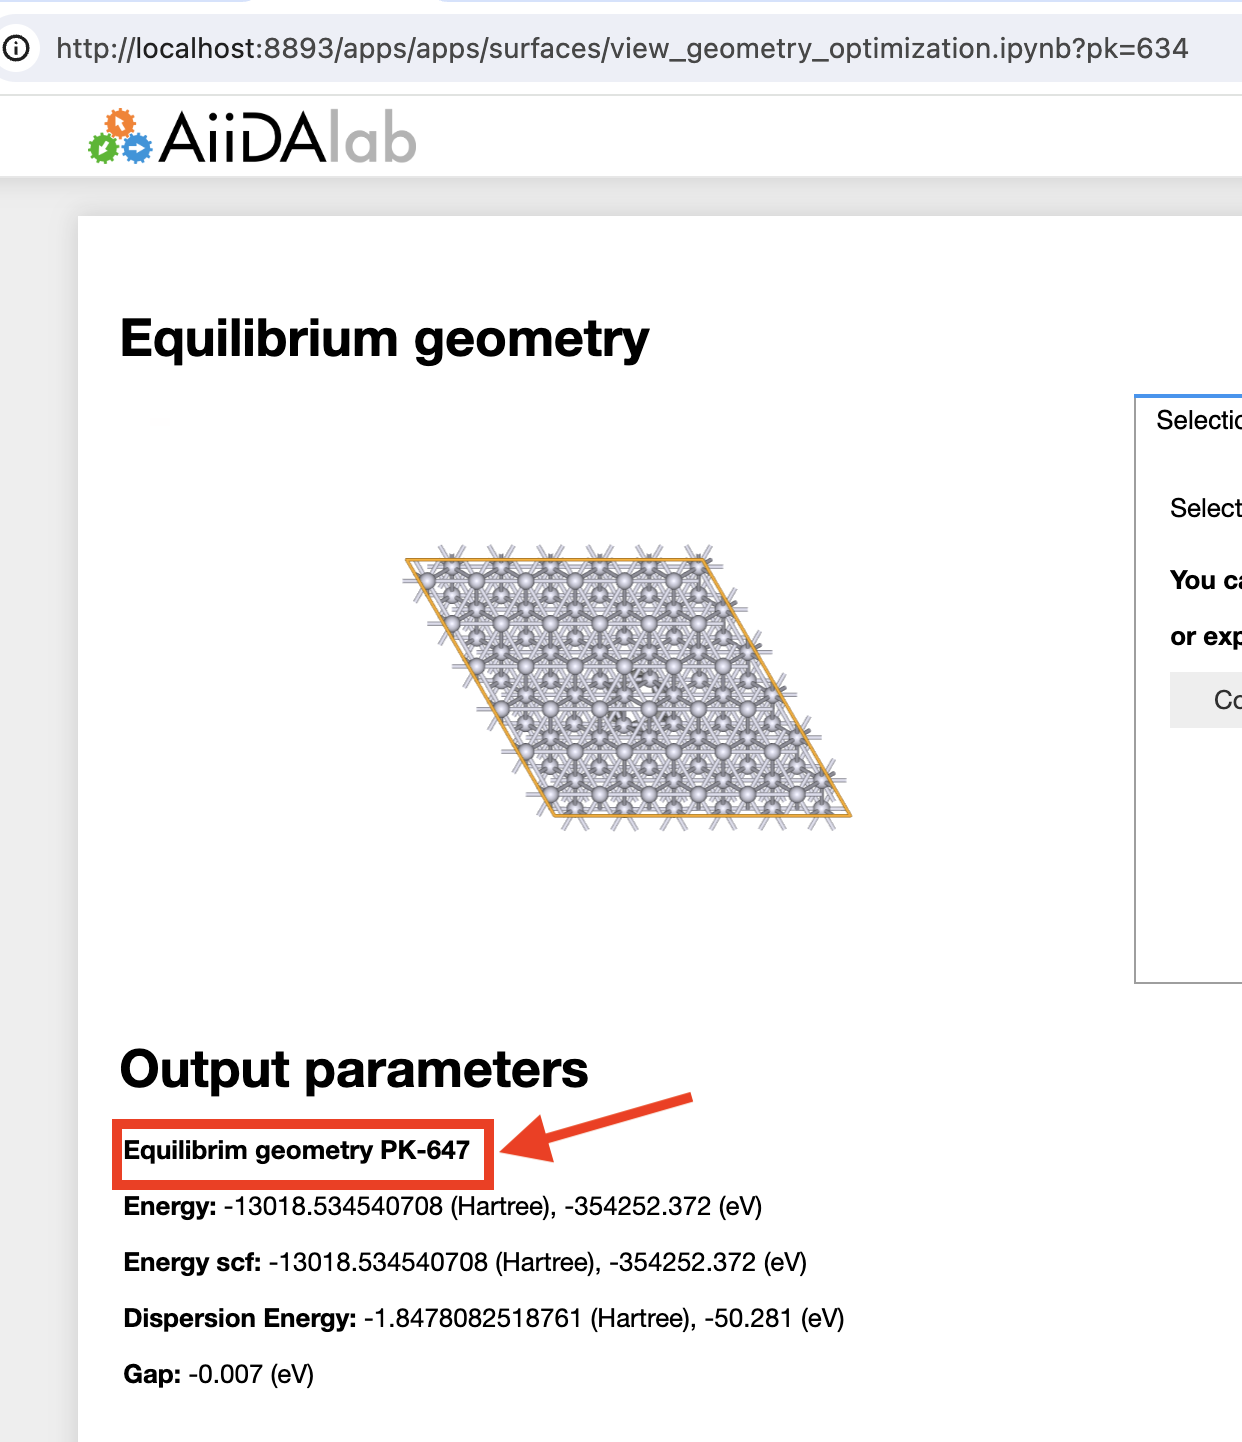


In [42]:
%load_ext aiida
%aiida


pk_benz_on_pt = 634
pk_opt_benz_on_pt = 647
pk_pt_frozen = 0
pk_benz_frozen = 0

pk_meth_on_pt = 0
pk_etha_on_pt  = 0


The aiida extension is already loaded. To reload it, use:
  %reload_ext aiida


### The problem of the cell and of the coordinates.

To compute density differences, we need to subtract cubefiles with exactly the same cell, and with the same geometries. We need to compute **a single energy** with fixed nuclei for the slab in the same configuration as in the **benz_on_pt** and for the molecule, also in the same configuration.
To this end, we launch a scf run starting from **pk_opt_benz_on_pt**, we delete the benzene molecule, and we fix all the atoms. 

### Task 1: SCF Energy run on Pt frozen

1. Launch a geometry optimization starting from pk_opt_benz_on_pt
2. Delete the benzene molecule (Apply selection to: **name not Pt** )
3. Set "low accuracy" and "keep periodic"
4. fix all the atoms (Apply selection to: **name Pt**, in the existing "constraint" window add `fixed xyz 1..xxx`    where xxx is the final index of the selected atoms )
5. run on daint on 4 nodes and with name pt_frozen
6. add in the cell above the pk of this optimization (`pk_pt_frozen = ... `)

### Task 2: SCF Energy run on Molecule frozen

1. Launch a geometry optimization starting from pk_opt_benz_on_pt
2. Delete the Pt molecule (Apply selection to: **name Pt** )
3. Set "low accuracy" and "keep periodic"
4. fix all the atoms (Apply selection to: **name not Pt**, add constraint `fixed xyz 1..xxx` where xxx is the final index of the selected atoms )
5. run on daint on 4 nodes and with name benzene_frozen
6. add in the cell above the pk of this optimization (`pk_benz_frozen = ... `)

In [46]:
from ase.visualize import view
from ase.io import read
import nglview as nv

### Task 3: loading the necessary cubefiles from the three simulations.

1. The database contains the path of the remote folder on daint where the three runs were run. For the full system, we copy it into `benz_on_pt.cube`
```
c = load_node(pk_benz_on_pt)
mydir=c.outputs.remote_folder.get_remote_path()
!scp daint.cscs.ch:{mydir}/*DENS*cube benz_on_pt.cube
```
2. Do the same using pk_pt_frozen and copy on pt_frozen.cube
3. Do the same using pk_benz_frozen and copy on benz_frozen.cube
4. **From a terminal** use the software cubecruncher.x which is in the `Exercise_12` folder to perform a double subtraction of the cubefiles:
```
./cubecruncher.x -i benz_on_pt.cube -subtract benz_frozen.cube -o temp.cube
./cubecruncher.x -i temp.cube -subtract pt_frozen.cube -o diff_benz_on_pt.cube
```
5. At the end the file `diff_benz_on_pt.cube` contains the bonding density difference. We can plot it. 
6. Change the value of the + and - isolevels. Where is the accumulation of charge, that corresponds to **bonding** ? Do you see only one type of bonding between the carbon atoms and the Pt atoms?

In [55]:

file = 'diff.cube'
atoms = read(file)
my_ind_sub = [atom.index for atom in atoms if (atoms.get_atomic_numbers()[atom.index] == 78)]
my_ind_mol = [atom.index for atom in atoms if (atoms.get_atomic_numbers()[atom.index] != 78)]
print (my_ind_mol)

view = nv.NGLWidget()
view.add_component(nv.ASEStructure(atoms))
view.clear_representations()
view.add_representation('spacefill',selection=my_ind_sub,color="grey",radius=0.4)
view.add_ball_and_stick(selection=my_ind_mol,color="green")


c_2 = view.add_component(file)
c_2.clear()
c_2.add_surface(color='blue', isolevelType="value", isolevel=-0.01, opacity=0.05)

c_3 = view.add_component(file)
c_3.clear()
c_3.add_surface(color='red', isolevelType="value", isolevel=+0.01, opacity=0.05)

view

[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


NGLWidget()

### Task 4: Repeat with the other two molecules.

## Part 2: Vibrational spectrum of benzene and methanol


In this Exercise we will compute the vibrational spectrum of two molecules (methanol
and benzene). This will be done with two different methods, namely with a static method
(diagonalization of the dynamical matrix) and with molecular dynamics. The spectra for
methanol can be compared with [this paper](https://pubs.rsc.org/en/content/articlelanding/2013/CP/c3cp44302g#!divAbstract).

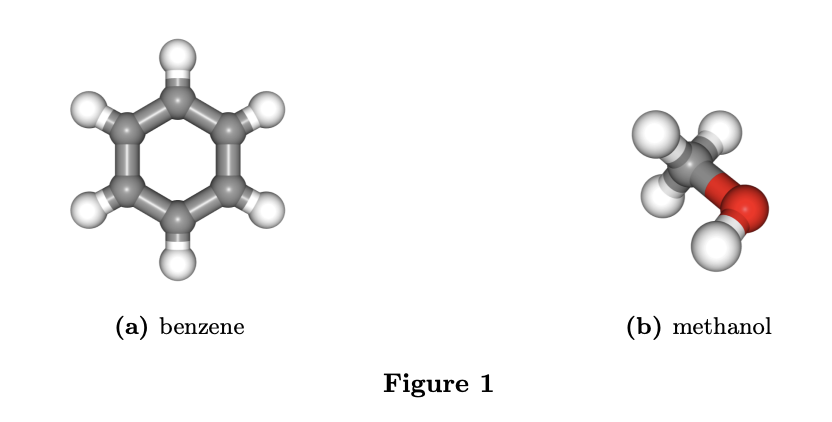

This will involve runs that we will run on the scratch of daint (not with **aiidalab**). So the first thing to do will be to copy to daint the whole tree `Runs_12` that you have in your folder. From a terminal, hit:

```
cd MMM_2024/Exercise_12
scp -r Runs_12 daint.cscs.ch:/scratch/snx3000/courseXXX/
```

(put your account name instead of courseXXX)

Then go to daint from a terminal:

```
ssh daint.cscs.ch
cd $SCRATCH
cd Runs_12
```



## Static calculations


1. On daint, cd to the static directory

To compute the vibrational spectra with this technique, it is necessary to start from minimum energy structures for the systems. The latter are contained in the **optc6h6.xyz** and
**optmet.xyz** files. The corresponding input files are `vibc6h6.inp` and `vibmet.inp`. Their
structure resemble the one of the input files of the last lecture, with the exception of the
section for the vibrational spectra:

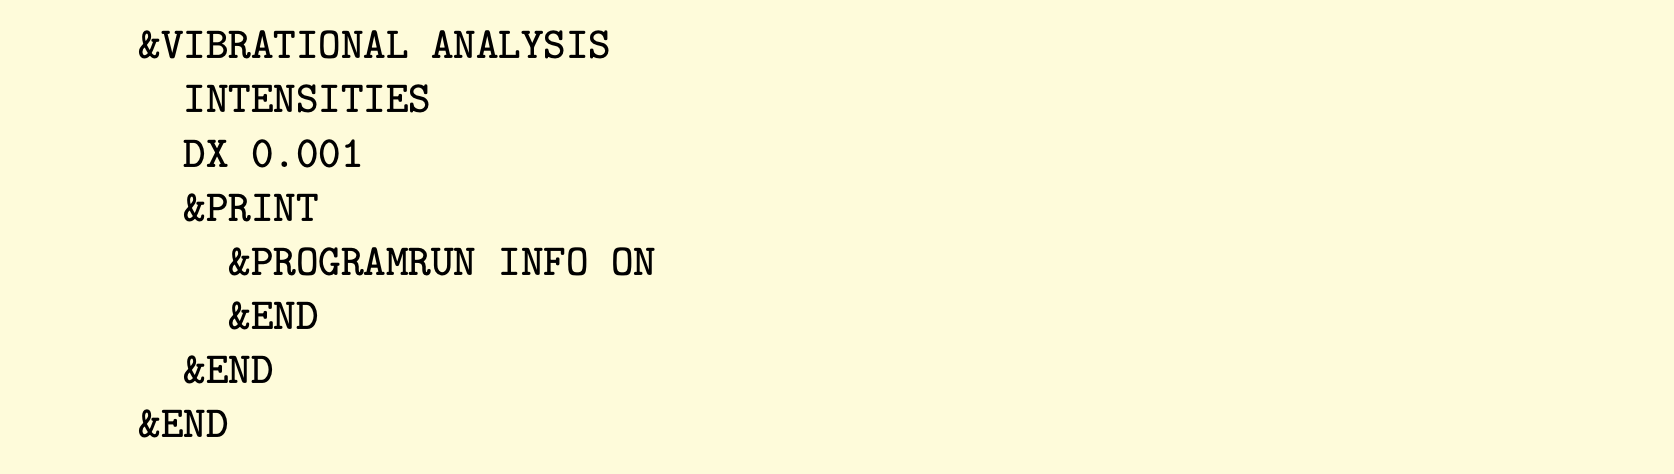

2. Submit the calculation with the submission script:

    sbatch vibmet.sh
    sbatch vibc6h6.sh
    
The resulting molden files (`*.mol`) contain the information about frequencies and intensities of the spectrum. Visualize them with vi (or `more`):

    vi C6H6-VIBRATIONS-1.mol
    vi MET-VIBRATIONS-1.mol
    
And have a look at the different sections. Analyze these files with the `Static.ipynb` present in the `static` directory on your aiidalab.
Theere are also `*.mol` files for c6h6 and methanol obtained with better precision (i.e. with
a different basis set). They terminate with `*.ref.mol`. Modify the notebook to analyze also
these files.


## Dynamics

All vibrational spectra calculated can be computed also from molecular dynamics (MD)
calculations, performing a Fourier transformation of certain autocorrelation functions. The
latter is chosen according to the spectra of interest: power spectra use the particle velocities, IR spectra rely on molecular dipole moments and Raman spectra are obtained from molecular polarizabilities. In this part of the exercise you will compute the vibrational spectra IR of methanol and benzene from density functional tight binding (DFTB) MD simulations. In the end you will be able to compare these results with those of the previous
section.

2. Move to the second directory:

```
cd ../dynamics/
````

As in the previous section, the starting points of the simulations are the optimized
geometries of the molecules, `optc6h6.xyz` and `optmet.xyz`, that are given as starting geometries in the input files mdc6h6.inp and mdmet.inp. You can visualized with vi:

    vi mdmet.inp
    
    
The DFTB section is given in the following:

    METHOD DFTB use DFTB method
    &DFTB
    SELF_CONSISTENT F use of self-consistent method
    DISPERSION F dispersion correction
    ORTHOGONAL_BASIS F Assume orthogonal basis set
    DO_EWALD F Use Ewald summation for Coulomb int.
    &PARAMETER
    PARAM_FILE_PATH ./dftb_params/scc name of parameter file
    PARAM_FILE_NAME scc_parameter
    UFF_FORCE_FIELD uff_table parameter file for dispersion corrections
    &END PARAMETER
    &END DFTB
    
    
Run CP2K for the two systems with the runmet and runc6h6 scripts:

    sbatch mdmet.sh
    sbatch mdc6h6.sh
    
The dipole moment and its derivatives are extracted from the simulations and saved in
files named `dip*traj` according to the input.
The post-process of these MD runs must be done with the Dipole_correlation.ipynb, so
copy everything on your local machine, using the terminal there:

```
cd /home/jovyan/MMM_2024/Exercise_12/dynamics
scp daint.cscs.ch:/scratch/snx3000/username/Runs_12/dynamics/md*out .
scp daint.cscs.ch:/scratch/snx3000/username/Runs_12/dynamics/*1.xyz .
scp daint.cscs.ch:/scratch/snx3000/username/Runs_12/dynamics/*traj .
```
Use the jupyter notebooks to analyse the output of the simulations done with both
the methods and compare the outcome. Repeat the same analysis with the reference
files (`*.ref.mol` for the static simulations and `long_*` for dynamics).